In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import napari


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

from skimage.measure import regionprops

import pathlib


import delta

We first find all data:

In [2]:
root = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'AgarPad')
image_dir = root / 'raw_data'
processed_dir = root / 'processed_data'
file_dirs = sorted(processed_dir.glob('Pos*'))
print(file_dirs)


[PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos01'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos01.pkl'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos02'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos03'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos04'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos05'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos06'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos07'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos08'), PosixPath('/Users/simonvanvliet/switchdrive/Biozentrum/AgarPad/processed_data/Pos09')]


Select a position:

In [3]:
pos_to_analyze = 0
# this loads the processed data
pos = delta.pipeline.Position(None,None,None)
cur_dir = file_dirs[pos_to_analyze]
file_path = sorted(cur_dir.glob('*.pkl'))[0]


Every package has it's own data format which makes data analysis hard if you use multiple of them. Here we thus convert the data to a standard format. Long-format table are well supported in general and are preferred by R / Panda etc.

Before doing that we have to add some extra lineage info:

In [4]:
def add_lineage_info(lin):
#first we give each sublineage a unique id
    unique_count = 0 
    for idx, cell in enumerate(lin.cells):
        
        ## create sublineage ID
        #keep track of division events
        div_event = np.array([d is not None for d in cell['daughters']])
        sublin_id = np.cumsum(div_event) 
        unique_id = sublin_id + unique_count
        
        
        empty_list = np.full_like(sublin_id, -1).tolist()
        ## find mother cell
        cell['lin_id'] = empty_list
        cell['sublin_idx'] = empty_list
        cell['mother_lin_id'] = empty_list
        cell['d1_lin_id'] = empty_list
        cell['d2_lin_id'] = empty_list

        mom_idx = cell['mother']
        birth_frm = cell['frames'][0]        
        if mom_idx is not None:
            mom = lin.cells[mom_idx]
            
            try:
                div_frm = mom['frames'].index(birth_frm-1)
                mom_lin_id = mom['lin_id'][div_frm]
                
                #find prev division
                div_events_mom = np.nonzero(np.array(mom['daughters'])[0:birth_frm])[0]
                start_idx = div_events_mom[-1] if div_events_mom.size > 0 else 0
                
                d2_temp = np.array(mom['d2_lin_id'])
                d2_temp[start_idx:birth_frm] = unique_count                
                mom['d2_lin_id'] = d2_temp.tolist()
                
            except:
                mom_lin_id = -1
        else:
             mom_lin_id = -1   
                    
        
        ## add mother and daughter info
        mother_sublin_id = unique_id.copy() - 1
        mother_sublin_id[sublin_id==0] = -1
        
        mother_lin_id = unique_id.copy() - 1
        mother_lin_id[sublin_id==0] = mom_lin_id

        unique_count += (np.sum(div_event) + 1)
        
        d1_lin_id = unique_id.copy() + 1
        d1_lin_id[d1_lin_id==d1_lin_id[-1]] = -1

        cell['sublin_idx'] = sublin_id.tolist()
        cell['lin_id'] = unique_id.tolist()
        cell['mother_lin_id'] = mother_lin_id.tolist()
        cell['d1_lin_id'] = d1_lin_id.tolist()
        
        
    return None


def add_segment_info(lin, label_stack):  
    
    rp = [regionprops(label_im) for label_im in label_stack]
    
    label_lut = []
    for cell_nr in lin.cellnumbers:
        cell_nr = cell_nr.copy()
        cell_nr.sort()
        label_lut.append(cell_nr)

    for idx, cell in enumerate(lin.cells):        
        cell_idx = cell['id'] #the number cell has in label image
        cell_frames = cell['frames'] #the frame the cell exists
                
        x_pos = np.full(len(cell_frames), np.nan)
        y_pos = np.full(len(cell_frames), np.nan)
        
        for f_idx, frame in enumerate(cell_frames):
            rp_idx = label_lut[frame].index(cell_idx)
            centroid = rp[frame][rp_idx].centroid
            
            if len(centroid) == 2:
                x_pos[f_idx] = centroid[1]
                y_pos[f_idx] = centroid[0]
                
        lin.cells[idx]['x_pos'] = x_pos.tolist()
        lin.cells[idx]['y_pos'] = y_pos.tolist()
        
    return None

def lin_to_df(roi):
    label_stack = roi.label_stack
    lin = roi.lineage

    #find vector based data
    add_lineage_info(lin)
    add_segment_info(lin, label_stack)

    vector_data = []
    [vector_data.append(key) for key in lin.cells[0].keys() if isinstance(lin.cells[0][key], list)]
    #create data frame
    df = pd.DataFrame(lin.cells)
    #explode time into separate rows
    df = df.explode(vector_data)
    df = df.reset_index(drop=True)
    
    return df



In [5]:
pos.load(file_path)
data = lin_to_df(pos.rois[0])
data.head()

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,fluo1,lin_id,sublin_idx,mother_lin_id,d1_lin_id,d2_lin_id,x_pos,y_pos
0,0,NaN,0,None,"[284, 365]","[255, 387]",,46.611313,11.645064,414.5,46,238.792576,0,0,-1,1,11,376.5,269.565502
1,0,NaN,1,None,"[286, 363]","[258, 383]",,46.238667,11.800332,427.5,48,243.961783,0,0,-1,1,11,374.528662,271.129512
2,0,NaN,2,None,"[291, 359]","[262, 381]",,47.418701,11.645064,424.0,43,253.923077,0,0,-1,1,11,370.84188,276.106838
3,0,NaN,3,None,"[297, 357]","[268, 378]",,47.796772,11.904551,435.0,52,261.135417,0,0,-1,1,11,368.84375,281.85
4,0,NaN,4,None,"[295, 356]","[265, 378]",,48.004536,11.916937,440.5,44,259.417695,0,0,-1,1,11,368.602881,279.300412


In [6]:
# from IPython.display import display
# display(data.iloc[18:22,:])
# display(data.iloc[90:95,:])

In [7]:
temp_graph = np.vstack([data["lin_id"].to_numpy(dtype=np.float64), 
                      data["mother_lin_id"].to_numpy(dtype=np.float64)]).T

In [8]:

lin_data = np.vstack([data["lin_id"].to_numpy(dtype=np.double), 
                      data["frames"].to_numpy(dtype=np.double), 
                      data["y_pos"].to_numpy(dtype=np.double), 
                      data["x_pos"].to_numpy(dtype=np.double)]).T
lin_data.shape

lin_data = np.round(lin_data).astype(int)

lin_id = data["lin_id"].to_numpy(dtype=np.int32)
mom_id = data["mother_lin_id"].to_numpy(dtype=np.int32)

lin_set, idx_set = np.unique(lin_id, return_index=True)
mom_set = mom_id[idx_set]

graph = {}

for lin, mom in zip(lin_set, mom_set):
    if mom >= 0:
        graph[lin] = mom



In [9]:
rois = pos.rois[0]

imstack = np.stack(pos.rois[0].img_stack, axis=0)
labelstack = np.stack(pos.rois[0].label_stack, axis=0)
labelstack_raw = labelstack.copy()

viewer = napari.view_image(imstack)
viewer.add_labels(labelstack)
viewer.add_tracks(lin_data, name='Tracks', graph=graph)

viewer.show()


/Users/simonvanvliet/opt/miniconda3/envs/i2i_p1_env/lib/python3.10/site-packages/superqt/qtcompat/__init__.py:7: UserWarning: The superqt.qtcompat module is deprecated as of v0.3.0. Please import from `qtpy` instead.
  warnings.warn(
2022-04-19 08:16:56.295715: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/simonvanvliet/opt/miniconda3/envs/i2i_p1_env/lib/python3.10/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.t

None None []


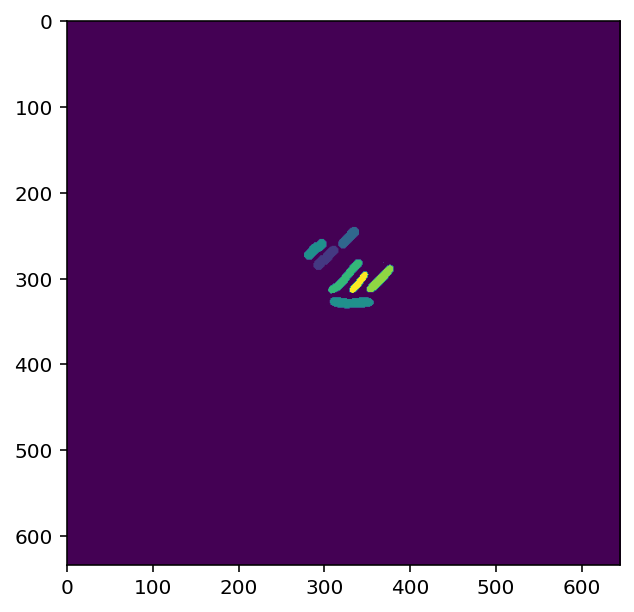

In [11]:
frame = 39

fig, axs = plt.subplots(1,2, figsize=(16,24))
axs[0].imshow(labelstack_raw[frame,:,:])
axs[1].imshow(labelstack[frame,:,:])    